# Environment

In [5]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [6]:
# Set the current working directory
os.chdir('/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_MECP2')

# Load Data

## Fold Change

In [7]:
DEA_NEU = pd.read_csv("./DATA/DEA_NEU.csv", header=0)
DEA_NSC = pd.read_csv("./DATA/DEA_NSC.csv", header=0)

In [8]:
DEA_NEU.head()

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,H2afy2,898.006083,-0.000002,0.096164,-0.000017,0.999986,0.999986
1,Lurap1l,248.853019,0.000021,0.175418,0.000119,0.999905,0.999970
2,Tcea1,1680.603269,0.000090,0.088197,0.001019,0.999187,0.999963
3,Igdcc4,872.289717,0.000126,0.100337,0.001255,0.998999,0.999963
4,Kdm6a,792.508606,-0.000035,0.108607,-0.000325,0.999741,0.999963


In [9]:
DEA_NEU.shape

(12945, 7)

In [10]:
DEA_NEU = DEA_NEU[DEA_NEU['padj'] < 0.05]
DEA_NSC = DEA_NSC[DEA_NSC['padj'] < 0.05]

In [11]:
print(DEA_NEU.shape)
print(DEA_NSC.shape)

(2115, 7)
(8908, 7)


In [12]:
DEA_NEU.head()

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
10830,Etohd2,52.179960,-0.875472,0.325480,-2.689789,0.007150,0.049950
10831,Prepl,6734.833093,-0.182629,0.067887,-2.690180,0.007141,0.049914
10832,Slk,2299.724144,-0.235697,0.087604,-2.690482,0.007135,0.049914
10833,Tomm34,630.507422,-0.309322,0.114977,-2.690304,0.007139,0.049914
10834,Selenon,323.325362,-0.378338,0.140572,-2.691420,0.007115,0.049798


## MECP2

In [13]:
mecp2_NEU = pd.read_csv("./DATA/allgenes_NEU.csv", header=0)
mecp2_NSC = pd.read_csv("./DATA/allgenes_NSC.csv", header=0)

In [14]:
print(mecp2_NEU.shape)
print(mecp2_NSC.shape)

(80, 6)
(467, 6)


In [15]:
mecp2_NEU.head()

,gene,baseMean,log2FoldChange,Direction,Endogenous_Promoter,Exogenous_Promoter
0,Abcg2,230.797511,0.825216,UP,False,True
1,AW551984,581.286456,0.749896,UP,False,True
2,Bend5,155.132445,0.577849,UP,False,True
3,Cgn,176.027310,0.683605,UP,False,True
4,Crhr2,85.668042,0.805206,UP,False,True


# Histone Marks

In [17]:
histone_marks = pd.read_csv("./DATA/histone_marks.csv", header=0)


In [18]:
histone_marks.head()

,NEU,NPC
0,Xkr4,Xkr4
1,Sntg1,Oprk1
2,Rrs1,Npbwr1
3,Prex2,Alkal1
4,Msc,Sntg1


In [19]:
histone_marks_neu = histone_marks['NEU']
histone_marks_npc = histone_marks['NPC']


In [20]:
histone_marks_neu.dropna(inplace=True)
histone_marks_npc.dropna(inplace=True)
print(histone_marks_neu.shape)
print(histone_marks_npc.shape)

(1523,)
(3171,)


In [21]:
histone_marks_neu = list(histone_marks_neu)
histone_marks_npc = list(histone_marks_npc)

# Plots

In [22]:
def volcano_plot(df1, df2, histone_marks=None, p_value_threshold=0.05, fc_threshold=1, labels=True, promoter_type='Exogenous_Promoter', size=10):
    # Calculate -log10(pvalue) for df1
    df1['neg_log_pvalue'] = -np.log10(df1['padj'])

    # Create a color mapping based on df2
    color_mapping = {}
    alpha_mapping = {}
    size_mapping = {}
    
    # Set default color/alpha for genes not in df2
    for gene in df1['gene']:
        color_mapping[gene] = 'lightgrey'
        alpha_mapping[gene] = 0.3
        size_mapping[gene] = size  
    
    if histone_marks is not None:
        for gene in df1['gene']:
            if gene in histone_marks:
                color_mapping[gene] = 'yellow'
                alpha_mapping[gene] = 0.8
                size_mapping[gene] = 2*size

    # Override for genes found in df2
    for gene in df2['gene'].values:
        if gene in df1['gene'].values:
            if df2[df2['gene'] == gene][promoter_type].iloc[0]:
                if df2[df2['gene'] == gene]['log2FoldChange'].iloc[0] > 0:
                    color_mapping[gene] = 'green'
                    alpha_mapping[gene] = 0.8
                    size_mapping[gene] = 2*size  
                if df2[df2['gene'] == gene]['log2FoldChange'].iloc[0] < 0:
                    color_mapping[gene] = 'red'
                    alpha_mapping[gene] = 0.8
                    size_mapping[gene] = 2*size  

    # Create color list in the same order as df1
    colors = [color_mapping[gene] for gene in df1['gene']]
    alphas = np.array([alpha_mapping[gene] for gene in df1['gene']])
    sizes = np.array([size_mapping[gene] for gene in df1['gene']])
    plt.figure(figsize=(10, 8))

    # Plot background points first (lightgrey)
    background_mask = np.array([c == 'lightgrey' for c in colors])
    plt.scatter(df1.loc[background_mask, 'log2FoldChange'],
            df1.loc[background_mask, 'neg_log_pvalue'],
            c='lightgrey',
            alpha=alphas[background_mask],
            s=sizes[background_mask])

    # Plot yellow points (histone marks)
    yellow_mask = np.array([c == 'yellow' for c in colors])
    plt.scatter(df1.loc[yellow_mask, 'log2FoldChange'],
            df1.loc[yellow_mask, 'neg_log_pvalue'],
            c='yellow',
            alpha=alphas[yellow_mask],
            s=sizes[yellow_mask])

    # Plot colored points on top (red/green)
    colored_mask = np.array([c in ['red', 'green'] for c in colors])
    plt.scatter(df1.loc[colored_mask, 'log2FoldChange'],
            df1.loc[colored_mask, 'neg_log_pvalue'],
            c=[c for c, m in zip(colors, colored_mask) if m],
            alpha=alphas[colored_mask],
            s=sizes[colored_mask])

    # Add labels and title
    plt.xlabel('log2 Fold Change', fontsize=12)
    plt.ylabel('-log10(p-value)', fontsize=12)
    plt.title('Volcano Plot of Differential Expression', fontsize=14)

    # Add a grid
    plt.grid(True, linestyle='--', alpha=0.7)

    # Create custom legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', 
                    markerfacecolor='red', label=f'\n\n{promoter_type} Enriched', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', 
                    markerfacecolor='green', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w',
                    markerfacecolor='yellow', label='Histone Marks', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', 
                    markerfacecolor='lightgrey', label='Not in df2', markersize=7)
    ]

    plt.legend(handles=legend_elements, loc='upper right')

    if labels:
        # Add gene labels for significant genes
        pvalue_threshold = -np.log10(p_value_threshold)
        fc_threshold = fc_threshold 

        for idx, row in df1.iterrows():
            if (abs(row['log2FoldChange']) > fc_threshold) and (row['neg_log_pvalue'] > pvalue_threshold):
                plt.annotate(row['gene'], 
                            (row['log2FoldChange'], row['neg_log_pvalue']),
                            xytext=(5, 5), 
                            textcoords='offset points',
                            fontsize=8)

    plt.tight_layout()

    plt.show()

/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


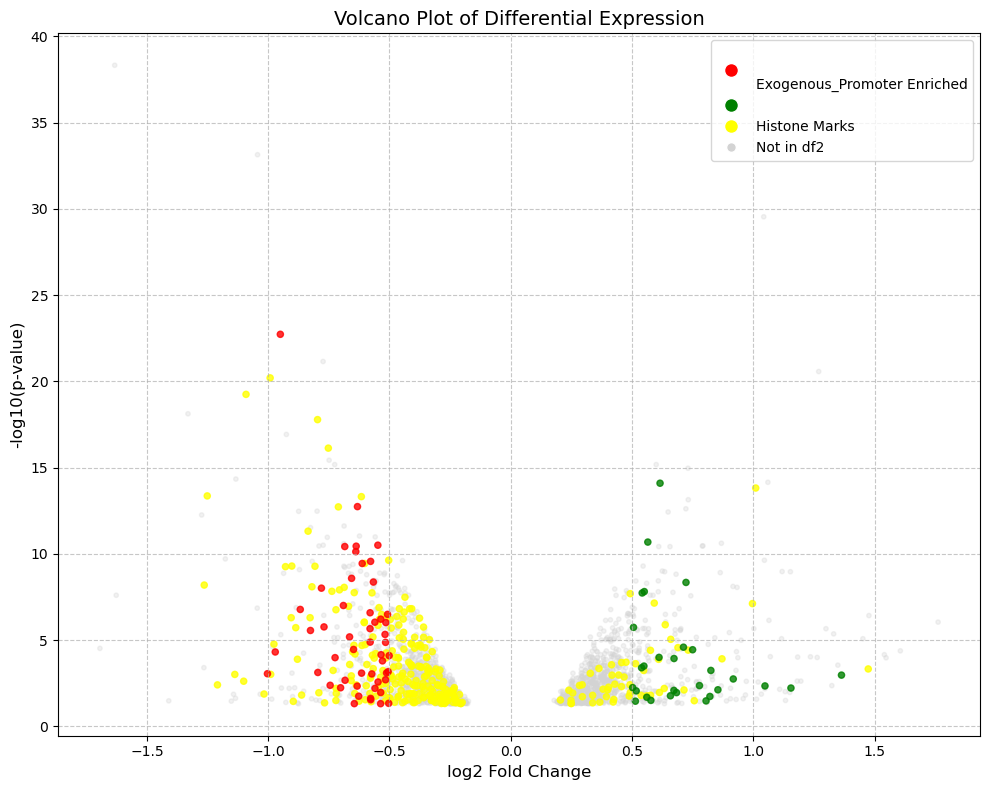

In [23]:
volcano_plot(DEA_NEU, mecp2_NEU, p_value_threshold=0.05, fc_threshold=1, labels=False, histone_marks=histone_marks_neu, size=10)

/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


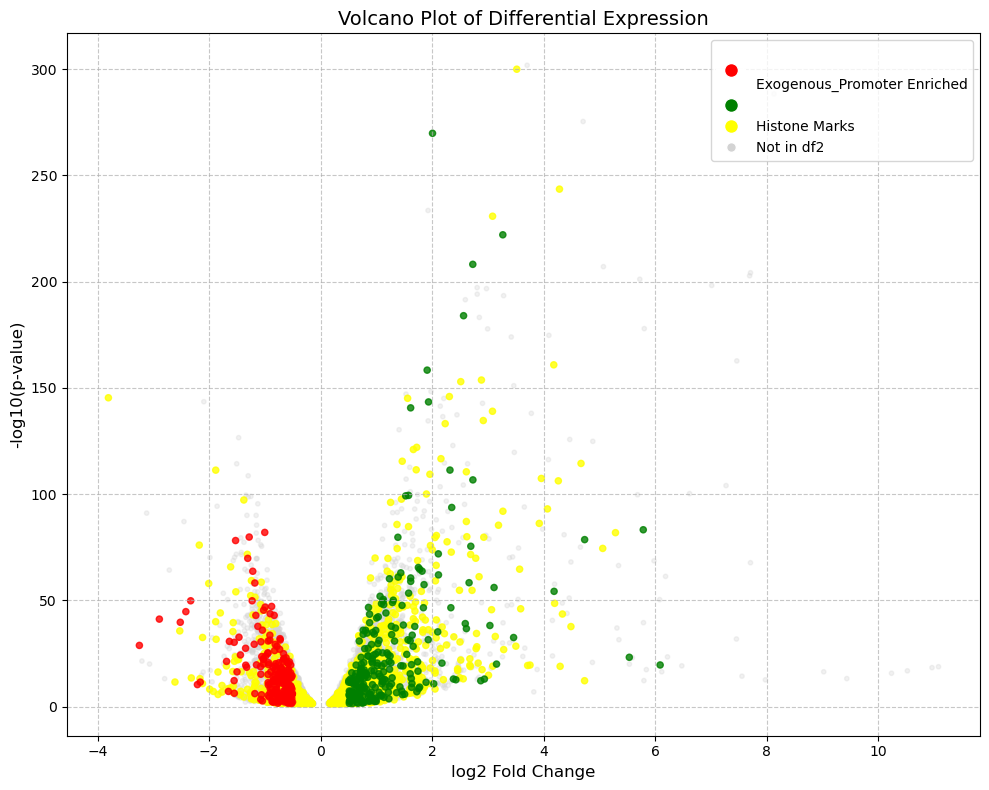

In [24]:
volcano_plot(DEA_NSC, mecp2_NSC, p_value_threshold=0.05, fc_threshold=4, labels=False, histone_marks=histone_marks_npc, size=10)

In [25]:
def volcano_plot_data(df1, df2, histone_marks=None, p_value_threshold=0.05, fc_threshold=1, promoter_type='Exogenous_Promoter', size=10):
    # Calculate -log10(pvalue) for df1
    df1['neg_log_pvalue'] = -np.log10(df1['padj'])

    # Create a color mapping based on df2
    color_mapping = {}
    alpha_mapping = {}
    size_mapping = {}
    
    # Set default color/alpha for genes not in df2
    for gene in df1['gene']:
        color_mapping[gene] = 'lightgrey'
        alpha_mapping[gene] = 0.3
        size_mapping[gene] = size 

    if histone_marks is not None:
        for gene in df1['gene']:
            if gene in histone_marks:
                color_mapping[gene] = 'yellow'
                alpha_mapping[gene] = 0.8
                size_mapping[gene] = 2*size 

    # Override for genes found in df2
    for gene in df2['gene'].values:
        if gene in df1['gene'].values:
            if df2[df2['gene'] == gene][promoter_type].iloc[0]:
                if df2[df2['gene'] == gene]['log2FoldChange'].iloc[0] > 0:
                    color_mapping[gene] = 'green'
                    alpha_mapping[gene] = 0.8
                    size_mapping[gene] = 2*size  
                if df2[df2['gene'] == gene]['log2FoldChange'].iloc[0] < 0:
                    color_mapping[gene] = 'red'
                    alpha_mapping[gene] = 0.8
                    size_mapping[gene] = 2*size  

    # Create color list in the same order as df1
    colors = [color_mapping[gene] for gene in df1['gene']]
    alphas = [alpha_mapping[gene] for gene in df1['gene']]
    sizes = [size_mapping[gene] for gene in df1['gene']]

    # Create masks for different point types
    background_mask = [c == 'lightgrey' for c in colors]
    yellow_mask = [c == 'yellow' for c in colors]
    colored_mask = [c in ['red', 'green'] for c in colors]

    # Prepare data structures for each point type
    background_data = {
        'x': df1.loc[background_mask, 'log2FoldChange'].values,
        'y': df1.loc[background_mask, 'neg_log_pvalue'].values,
        'alpha': [a for a, m in zip(alphas, background_mask) if m],
        'size': [s for s, m in zip(sizes, background_mask) if m]
    }
    
    yellow_data = {
        'x': df1.loc[yellow_mask, 'log2FoldChange'].values,
        'y': df1.loc[yellow_mask, 'neg_log_pvalue'].values,
        'alpha': [a for a, m in zip(alphas, yellow_mask) if m],
        'size': [s for s, m in zip(sizes, yellow_mask) if m]
    }
    
    colored_data = {
        'x': df1.loc[colored_mask, 'log2FoldChange'].values,
        'y': df1.loc[colored_mask, 'neg_log_pvalue'].values,
        'colors': [c for c, m in zip(colors, colored_mask) if m],
        'alpha': [a for a, m in zip(alphas, colored_mask) if m],
        'size': [s for s, m in zip(sizes, colored_mask) if m]
    }

    # Prepare label data for significant genes
    label_data = None
    if abs(fc_threshold) > 0:
        pvalue_threshold = -np.log10(p_value_threshold)
        significant_mask = (abs(df1['log2FoldChange']) > fc_threshold) & (df1['neg_log_pvalue'] > pvalue_threshold)
        label_data = {
            'x': df1.loc[significant_mask, 'log2FoldChange'].values,
            'y': df1.loc[significant_mask, 'neg_log_pvalue'].values,
            'labels': df1.loc[significant_mask, 'gene'].values
        }

    return {
        'background': background_data,
        'histone': yellow_data,
        'colored': colored_data,
        'labels': label_data
    }

In [26]:
def plot_volcanoes_side_by_side(data1, data2, titles=('Plot 1', 'Plot 2'), 
                               promoter_type='Exogenous_Promoter', 
                               x_limits=(-5, 15), y_limits=(0, 320)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Helper function to plot on a given axis
    def plot_on_axis(ax, data):
        # Plot background points
        ax.scatter(data['background']['x'], data['background']['y'], 
                  c='lightgrey', alpha=data['background']['alpha'],
                  s=data['background']['size'])
        
        # Plot histone marks if present
        if len(data['histone']['x']) > 0:
            ax.scatter(data['histone']['x'], data['histone']['y'],
                      c='yellow', alpha=data['histone']['alpha'],
                      s=data['histone']['size'])
        
        # Plot colored points
        ax.scatter(data['colored']['x'], data['colored']['y'],
                  c=data['colored']['colors'], alpha=data['colored']['alpha'],
                  s=data['colored']['size'])
        
        # Add labels if present
        # if data['labels'] is not None:
        #     for x, y, label in zip(data['labels']['x'], data['labels']['y'], 
        #                          data['labels']['labels']):
        #         ax.annotate(label, (x, y), xytext=(5, 5), 
        #                    textcoords='offset points', fontsize=8)
    
    # Plot both datasets
    plot_on_axis(ax1, data1)
    plot_on_axis(ax2, data2)
    
    # Configure axes
    for ax, title in zip([ax1, ax2], titles):
        ax.set_xlabel('log2 Fold Change', fontsize=12)
        ax.set_ylabel('-log10(p-value)', fontsize=12)
        ax.set_title(title, fontsize=14)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_xlim(*x_limits)
        ax.set_ylim(*y_limits)
    
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', 
                  markerfacecolor='red', label=f'\n\n{promoter_type} Enriched', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', 
                  markerfacecolor='green', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w',
                  markerfacecolor='yellow', label='Histone Marks', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', 
                  markerfacecolor='lightgrey', label='Not in df2', markersize=7)
    ]
    
    fig.legend(handles=legend_elements, loc='center right')
    plt.tight_layout()
    
    return fig, (ax1, ax2)

/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


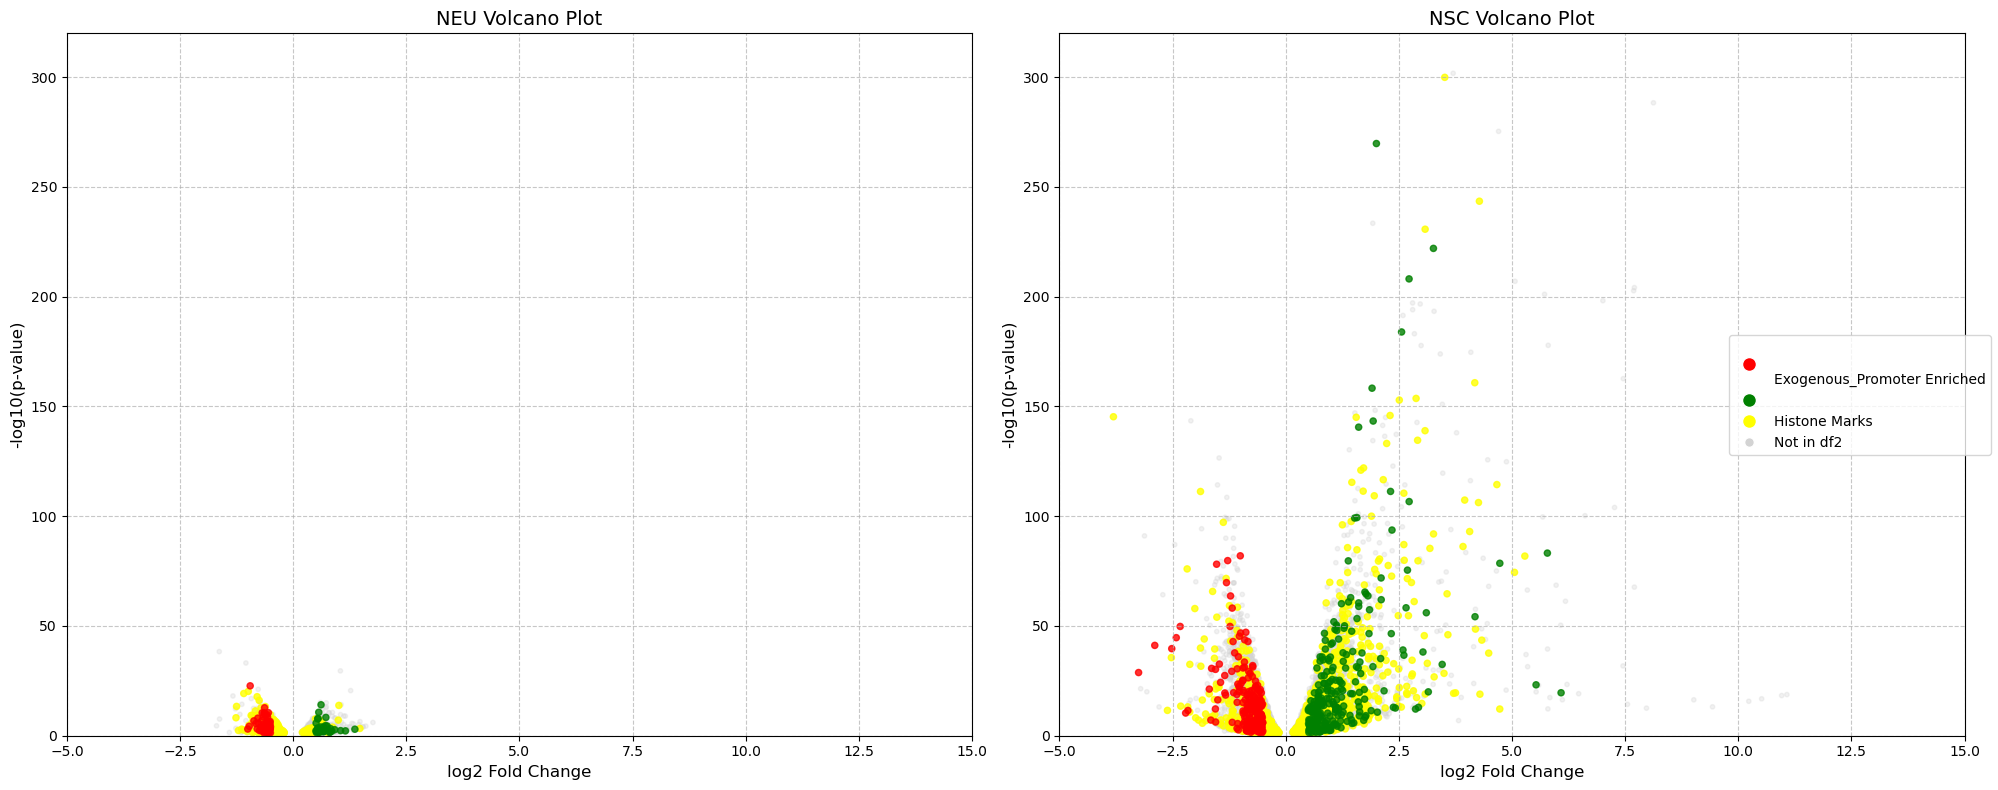

In [27]:
# Get the data
data1 = volcano_plot_data(DEA_NEU, mecp2_NEU, histone_marks=histone_marks_neu, size=10)
data2 = volcano_plot_data(DEA_NSC, mecp2_NSC, histone_marks=histone_marks_npc, size=10)

# Create the plots
fig, axes = plot_volcanoes_side_by_side(data1, data2, 
                                       titles=('NEU Volcano Plot', 'NSC Volcano Plot'))
plt.show()